In [1]:
# Indata.
# Produktion (kWh) - Från Ferroamp.
# Import (kWh), Export (kWh) - Från Tibber elräkning / api https://developer.tibber.com/explorer.
# Pris export (öre/kWh) - Medelpriset vi fått per såld kWh under månaden. Detta är spotpriset viktat efter vår export. Från Tibber elräkning / api.
# Pris Tibber (öre/kWh) - Medelpriset vi betalat per köpt kWh från Tibber utan moms och skatter. Detta är spotpriset viktat efter vår import. Från Tibber elräkning / api.
# Pris Kraftringen (öre/kWh) - Kraftringens rörliga elpris utan moms och skatter. Från https://www.kraftringen.se/privat/el/vara-elpriser/
# Alla priser utan moms.
data = {
    # Månad,    Produktion (kWh), Import (kWh), Export (kWh), Pris export (öre/kWh), Pris Tibber (öre/kWh), Pris Kraftringen (öre/kWh)
    "2023-03": [          606   ,      276.973,      419.006,                98.41,                  96.91, 158.79/1.25*0.85          ], # Från kraftringen.se TODO
    "2023-02": [          279   ,      272.988,      154.176,               106.49,                 113.70, 158.79/1.25               ], # Från kraftringen.se 2023-03-03
    "2023-01": [           95.01,      385.32 ,       24.274,               149.03,                 111.84, 159.20/1.25               ], # Från kraftringen.se 2023-02-04
    "2022-12": [           47.42,      447.953,        5.775,               260.90,                 271.27, 271.45+36.99+3.9          ],
    "2022-11": [          115.00,      404.086,       30.075,               103.52,                 144.24, 219.67/1.25               ],
    "2022-10": [          432.00,      324.757,      246.547,                89.42,                  82.92, 85.00                     ],
    "2022-09": [          400.00,      336.747,      272.157,               228.55,                   None, 251.89+3.2                ],
    "2022-08": [            None,      392.163,         None,                 None,                   None, 322.69+3.2                ],
    "2022-07": [            None,      376.626,         None,                 None,                   None, 130.61+3.2                ],
    "2022-06": [            None,      310.596,         None,                 None,                   None, 184.69+3.2                ],
    "2022-05": [            None,      410.56 ,         None,                 None,                   None, 144.4+3.2                 ],
    "2022-04": [            None,      401.256,         None,                 None,                   None, 115.07+3.2                ],
    "2022-03": [            None,      422.237,         None,                 None,                   None, 164.87+3.2                ],
    "2022-02": [            None,      394.466,         None,                 None,                   None, 90.71+3.2                 ],
    "2022-01": [            None,      498.1  ,         None,                 None,                   None, 120.2+3.2                 ],
}

# Övriga priser och skatter.
data2 = {
    # Från månad
    # Investering (kr)
    # Överföringsavgift (öre/kWh)
    # Elnät abonnemang (kr/månad)
    # Energiskatt (öre/kWh)
    # Skattereduktion (öre/kWh)
    # Nätnytta (öre/kWh)
    # Tibber abonnemang (kr/månad)
    # Kraftringen abonnemang (kr/månad)
    "2022-10": {                                                      "Tibber abonnemang": 31},
    "2022-08": {"Investering": 156265},
    "2022-07": {"Överföringsavgift": 19.60, "Elnät abonnemang": 336},
    "2022-01": {"Överföringsavgift": 18.00, "Elnät abonnemang": 308,  "Kraftringen abonnemang": 36, "Energiskatt": 36, "Nätnytta": 5, "Skattereduktion": 60},
}


In [2]:
# Uträkningar

import numpy as np
import pandas as pd

# Alla månader.
months = pd.DatetimeIndex((data | data2).keys()).sort_values()

columns = [
    'Pris Kraftringen',
    'Pris Tibber',
    'Pris export',
    'Produktion',
    'Export',
    'Import',
    'Egenförbrukning',
    'Förtjänst solceller',
    'Förtjänst timavläsning',
    'Restskuld',
    'Skattereduktion',
    'Nätnytta',
    'Investering',
    'Överföringsavgift',
    'Energiskatt',
    'Elnät abonnemang',
    'Tibber abonnemang',
    'Kraftringen abonnemang'
    ]

df = pd.DataFrame(columns=columns, index=months)
df.index.rename("Datum", inplace=True)

for m, row in data.items():
    if not row[0] is None: df.loc[pd.to_datetime(m), "Produktion"]       = row[0]
    if not row[1] is None: df.loc[pd.to_datetime(m), "Import"]           = row[1]
    if not row[2] is None: df.loc[pd.to_datetime(m), "Export"]           = row[2]
    if not row[3] is None: df.loc[pd.to_datetime(m), "Pris export"]      = row[3]
    if not row[4] is None: df.loc[pd.to_datetime(m), "Pris Tibber"]      = row[4]
    if not row[5] is None: df.loc[pd.to_datetime(m), "Pris Kraftringen"] = row[5]

df["Investering"] = 0
for m, row in data2.items():
    for k, v in row.items():
        df.loc[pd.to_datetime(m), k] = v

df.ffill(inplace=True)

Restskuld = np.nan
for m in df.index:
    #m = df.index[6]
    row = df.loc[m].fillna(0.0)
    #print(m)
    #print(row)
    if row["Produktion"] != 0.0:
        df.loc[m, "Räkning Kraftringen"] = ((row["Pris Kraftringen"]+row["Överföringsavgift"]+row["Energiskatt"])*row["Import"]/100.0+row["Kraftringen abonnemang"])*1.25 - \
            (row["Pris export"]+row["Skattereduktion"]+row["Nätnytta"])*row["Export"]/100.0
    df.loc[m, "Räkning Kraftringen utan solceller"] = ((row["Pris Kraftringen"]+row["Överföringsavgift"]+row["Energiskatt"])*(row["Import"]+row["Produktion"]-row["Export"])/100.0+row["Kraftringen abonnemang"])*1.25

    if row["Tibber abonnemang"] != 0.0:
        df.loc[m, "Räkning Tibber"] = ((row["Pris Tibber"]+row["Överföringsavgift"]+row["Energiskatt"])*row["Import"]/100.0+row["Tibber abonnemang"])*1.25 - \
            (row["Pris export"]+row["Skattereduktion"]+row["Nätnytta"])*row["Export"]/100.0

    row = df.loc[m].fillna(0.0)
    df.loc[m, "Egenförbrukning"] = np.nan
    df.loc[m, "Förtjänst solceller"] = np.nan
    if row["Produktion"] != 0.0:
        df.loc[m, "Egenförbrukning"] = (row["Produktion"]-row["Export"]) / row["Produktion"]
        df.loc[m, "Förtjänst solceller"] = row["Räkning Kraftringen utan solceller"] - row["Räkning Kraftringen"]
    df.loc[m, "Förtjänst timavläsning"] = np.nan
    if row["Tibber abonnemang"] != 0.0:
        df.loc[m, "Förtjänst timavläsning"] = row["Räkning Kraftringen"] - row["Räkning Tibber"]

    row = df.loc[m]
    Restskuld_change = 0.0
    if not np.isnan(row["Investering"]):
        Restskuld_change = Restskuld_change + row["Investering"]
    if not np.isnan(row["Förtjänst solceller"]):
        Restskuld_change = Restskuld_change - row["Förtjänst solceller"]
    if Restskuld_change != 0.0:
        if np.isnan(Restskuld):
            Restskuld = 0.0
        Restskuld = Restskuld + Restskuld_change
    df.loc[m, "Restskuld"] = Restskuld


In [3]:
# Tabell.
df.style \
    .format_index(lambda x: x.strftime('%Y-%m')).hide(axis="index", names=True) \
    .format(precision=0, na_rep='', thousands=" ",
        formatter={
            #"Pris Kraftringen": "{:.0f} öre/kWh",
            #"Pris Tibber": "asd",
            #"Pris export": "asd",
            "Egenförbrukning": lambda x: f"{x*100:.0f}%",
        }) \
    .hide(axis="columns", subset=["Nätnytta", "Skattereduktion", "Tibber abonnemang", "Kraftringen abonnemang", "Elnät abonnemang", "Investering", "Energiskatt", "Överföringsavgift"])


,Pris Kraftringen,Pris Tibber,Pris export,Produktion,Export,Import,Egenförbrukning,Förtjänst solceller,Förtjänst timavläsning,Restskuld,Räkning Kraftringen utan solceller,Räkning Kraftringen,Räkning Tibber
2022-01,123,,,,,498,,,,,1 150,,
2022-02,94,,,,,394,,,,,774,,
2022-03,168,,,,,422,,,,,1 217,,
2022-04,118,,,,,401,,,,,909,,
2022-05,148,,,,,411,,,,,1 080,,
2022-06,188,,,,,311,,,,,984,,
2022-07,134,,,,,377,,,,,937,,
2022-08,326,,,,,392,,,,156 265,1 915,,
2022-09,255,,229,400,272,337,32%,1 295,,154 970,1 849,554,
2022-10,85,83,89,432,247,325,43%,707,15,154 263,942,235,220


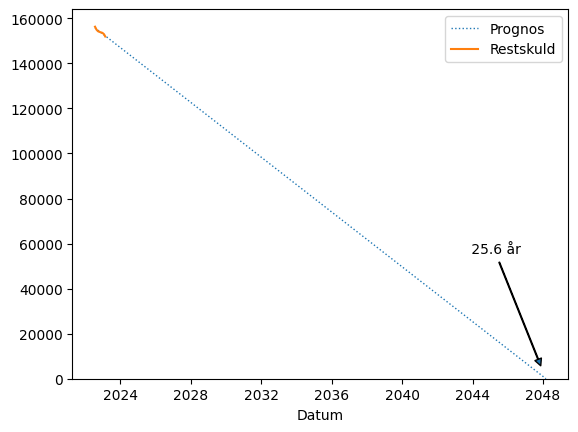

In [4]:
# Visualisera restskuld.

import matplotlib as mpl
import matplotlib.pyplot as plt

dfr = pd.DataFrame(df.loc["2022-08":, "Restskuld"])
t = [t.timestamp() for t in dfr.index]
line = np.polyfit(t, dfr["Restskuld"].values, 1)
zero = pd.to_datetime(-line[1] / line[0], unit="s").to_period("M").to_timestamp()

dfr.loc[dfr.index[0], "Prognos"] = 0.0
dfr.loc[zero, "Prognos"] = 0.0
for t in dfr.index:
    dfr.loc[t, "Prognos"] = line[1] + line[0]*t.timestamp()

fig, ax = plt.subplots()

ax.plot(dfr["Prognos"], label="Prognos", linewidth=1, linestyle=":")
ax.plot(dfr["Restskuld"], label="Restskuld")

ax.set_xlabel("Datum")
ax.legend()
ax.set_ylim(bottom=0)
_ = ax.annotate(f"{(zero - dfr.index[0]).total_seconds() / 3600 / 24 / 365.25 : .3n} år",
                va = "center", ha="center",
                xy=(zero, 0), xytext=(0.85, .35), textcoords="axes fraction")
_ = ax.annotate("",
                va = "center", ha="center",
                xy=(zero, 0), xytext=(0.85, .35), textcoords="axes fraction",
                arrowprops=dict(width=0.5, headwidth=5, headlength=5, shrink=0.1))
